Source: https://jacobgil.github.io/pytorch-gradcam-book/Pixel%20Attribution%20for%20embeddings.html

In [1]:
import glob, random

import torch
import torch.nn as nn
import torchvision.models as models
from torchvision.datasets import ImageFolder
from torchvision.transforms import v2
import torchvision.utils as utils

from PIL import Image

import cv2

from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad, EigenGradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

import matplotlib.pyplot as plt
import numpy as np

import ml_library as ML

In [2]:
# A model wrapper that gets a resnet model and returns the features before the fully connected layer.
class ResnetFeatureExtractor(torch.nn.Module):
    def __init__(self, model):
        super(ResnetFeatureExtractor, self).__init__()
        self.model = model
        self.feature_extractor = torch.nn.Sequential(*list(self.model.children())[:-1])
                
    def __call__(self, x):
        return self.feature_extractor(x)[:, :, 0, 0]

In [3]:
class SimilarityToConceptTarget:
    def __init__(self, features):
        self.features = features
    
    def __call__(self, model_output):
        cos = torch.nn.CosineSimilarity(dim=0)
        return cos(model_output, self.features)

In [4]:
def plot_samples(image_float, image_cam):

    fig, ax = plt.subplot_mosaic([
        ['image', 'cam']
    ], figsize=(15, 15))

    ax['image'].imshow(image_float)
    ax['image'].axis("off")

    ax['cam'].imshow(image_cam)
    ax['cam'].axis("off")

    plt.ioff()
    plt.show()

In [5]:
classes = [0, 1, 2, 3]
class_labels = ['CNV', 'DME', 'DRUSEN', 'NORMAL']

In [7]:
size = (224, 224)

# Transforms for test/val set
test_val_transform = v2.Compose([
    v2.Resize(size=(256,256)),
    v2.CenterCrop(size=size),
    v2.ToTensor(),
    # v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.1977, 0.1977, 0.1977], std=[0.1048, 0.1048, 0.1048]),
])

/root/miniconda3/envs/uECE189A/lib/python3.11/site-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [8]:
def get_rand_image_from_path(path):
    """A function that gets a random image in the path, 
    and returns a numpy image and a preprocessed
    torch tensor ready to pass to the model """

    img = np.array(Image.open(random.choice(glob.glob(path + '*.jpeg'))))

    input_tensor = test_val_transform(img)
    img = input_tensor.numpy().transpose((1, 2, 0))

    img_min = np.min(img)
    img_max = np.max(img)
    rgb_img_float = (img - img_min) / (img_max  - img_min)    

    return img, rgb_img_float, input_tensor.unsqueeze(0)

In [9]:
path_model_save = 'model/resnet50_model_87p.pth'

loaded_model = models.resnet50()
loaded_model.fc = nn.Linear(in_features=2048, out_features=(len(classes)), bias=True)
loaded_model.load_state_dict(torch.load(path_model_save))
loaded_model.eval()

# model = ResnetFeatureExtractor(loaded_model)
model = loaded_model

In [35]:
def OCT_grad_cam(path_to_image, model, class_labels):

    img, img_float, img_tensor = get_rand_image_from_path(path_to_image)

    output = model(img_tensor)
    _, predicted = torch.max(output.data, 1)
    percentage = torch.nn.functional.softmax(output.data, dim=1)[0] * 100

    img_concept_features = model(img_tensor)[0, :]

    target_layers = [model.layer4[-1]]

    img_targets = [SimilarityToConceptTarget(img_concept_features)]

    with EigenGradCAM(model=model, target_layers=target_layers, use_cuda=False) as cam:

        img_grayscale_cam = cam(input_tensor= img_tensor, targets=img_targets,
                                aug_smooth=True, eigen_smooth=True)[0, :]

    cam_image = show_cam_on_image(img_float, img_grayscale_cam, use_rgb=True)

    print(class_labels[predicted[0]], percentage[predicted[0]].item())
    plot_samples(img_float, cam_image)

In [10]:
path_to_folder = './data/test/'
path_to_CNV = path_to_folder + 'CNV/'
path_to_DME = path_to_folder + 'DME/'
path_to_DRUSEN = path_to_folder + 'DRUSEN/'
path_to_NORMAL = path_to_folder + 'NORMAL/'

CNV 92.21121978759766


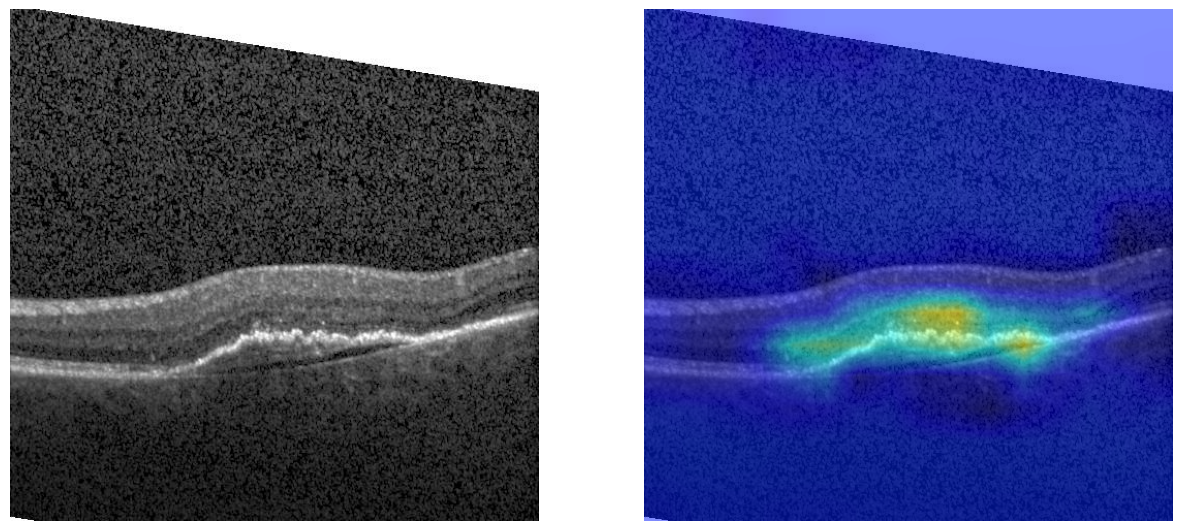

In [37]:
OCT_grad_cam(path_to_CNV, model, class_labels)

DME 90.929931640625


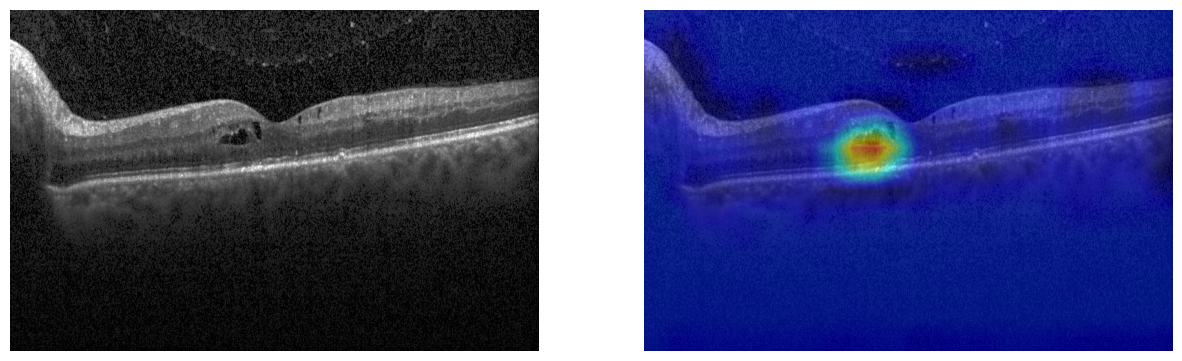

In [47]:
OCT_grad_cam(path_to_DME, model, class_labels)

DRUSEN 99.57350158691406


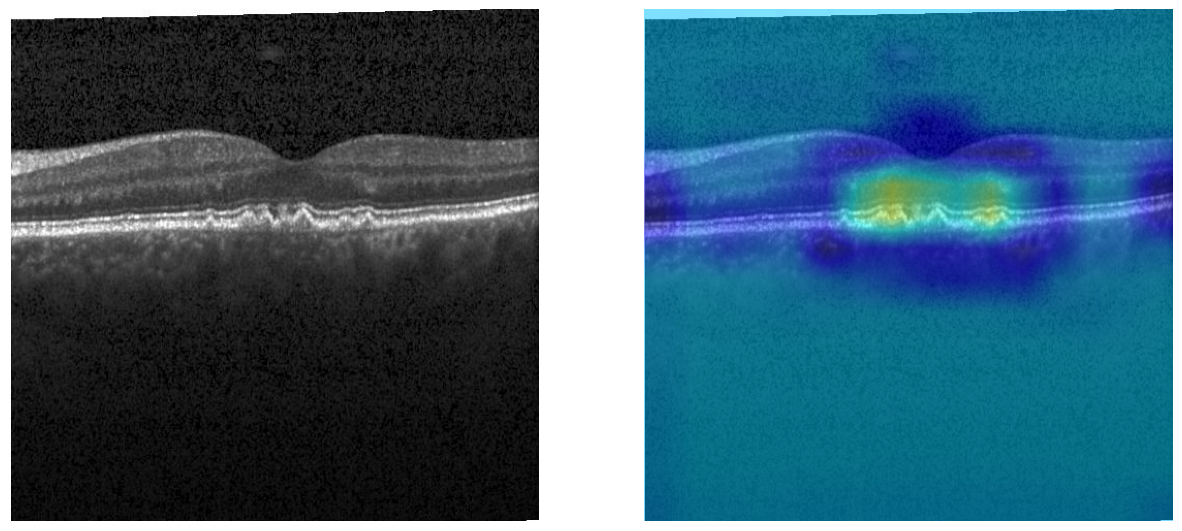

In [43]:
OCT_grad_cam(path_to_DRUSEN, model, class_labels)

NORMAL 99.40855407714844


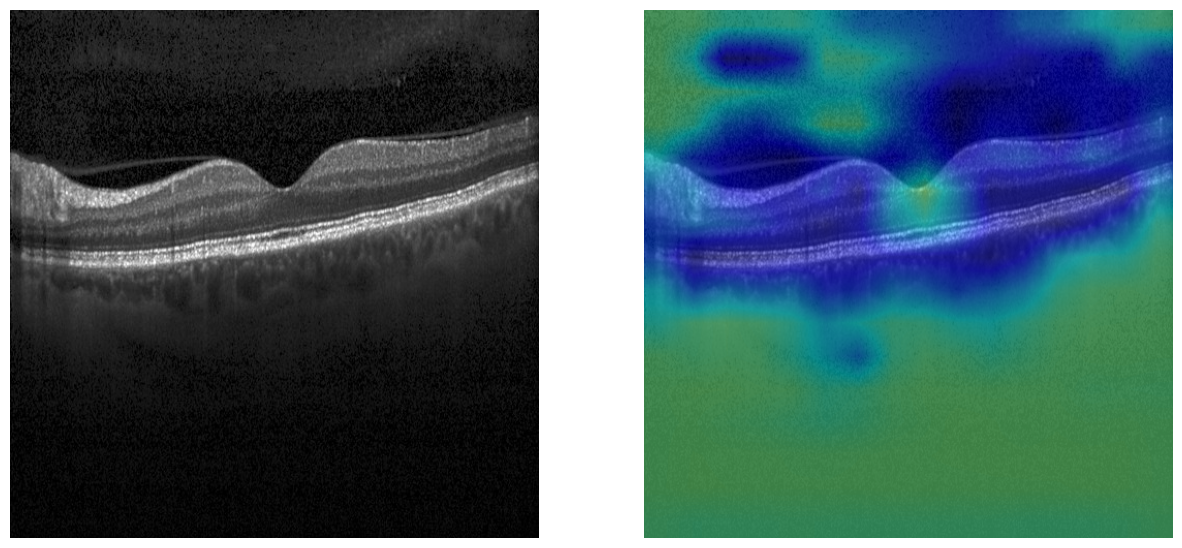

In [49]:
OCT_grad_cam(path_to_NORMAL, model, class_labels)